In [ ]:
!pip install ta-lib-bin numpy==1.26.4 stable-baselines3[extra]

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd

# 取得したい銘柄のコード
ticker_code = '5401.T'
# 保存するファイル名
file_name = 'Nipponsteel_stock_data2014~2024.csv'

print(f"銘柄コード'{ticker_code}'の株価データを取得します...")
df = yf.download(ticker_code, start='2014-01-01',end='2024-12-31')

if df.empty:
    print("エラー: データが取得できませんでした。")
else:
    # 取得したデータをCSVファイルとしてPCに保存
    df.to_csv(file_name)
    print(f"成功: データを'{file_name}'という名前で保存しました。")
    print("保存したデータの最初の5行を確認:")
    print(df.head())

銘柄コード'5401.T'の株価データを取得します...


/tmp/ipython-input-3314353640.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_code, start='2014-01-01',end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

成功: データを'Nipponsteel_stock_data2014~2024.csv'という名前で保存しました。
保存したデータの最初の5行を確認:
Price             Close         High          Low         Open   Volume
Ticker           5401.T       5401.T       5401.T       5401.T   5401.T
Date                                                                   
2014-01-06  2099.269287  2123.329680  2063.178698  2117.314582  4815800
2014-01-07  2087.239014  2117.314504  2069.193720  2087.239014  3393600
2014-01-08  2099.269287  2099.269287  2069.193796  2093.254189  3895200
2014-01-09  2069.193604  2087.238897  2051.148310  2081.223799  4618000
2014-01-10  2045.133057  2075.208543  2033.102862  2063.178348  4977500


In [ ]:
!pip install yfinance

In [ ]:
! pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
TRAINING_TIMESTEPS = 200000 # 1トライアルあたりの学習ステップ数（テストのため少し短縮）
NUM_TRIALS = 5# 試行回数

BEST_PARAMS = {
    'learning_rate': 0.003,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.05,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2014~2024.csv' # ファイル名はこれであってるで
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()
features_to_use = ['Close', 'MA5', 'MA25', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'BB_upper', 'BB_middle', 'BB_lower']
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], 12, 26, 9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], 20, 2, 2, 0)
df.dropna(inplace=True)
df_features = df[features_to_use]
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]
print("ステップ1: データ準備完了")
print("--------------------------\n")

# --- 2. カスタム環境定義 ---
# (StockTradingEnvクラスの定義は変更なし)
class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset # prev_total_assetを初期化
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]

        num_shares_to_buy = 0
        num_shares_to_sell = 0
        avg_price_at_sale_time = 0

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy * current_price > self.balance: # 所持金を超えないように調整
                num_shares_to_buy = int(self.balance / current_price)

            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held
                self.balance -= actual_cost

        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                avg_price_at_sale_time = self.average_purchase_price
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)
        reward = self.total_asset - self.prev_total_asset

        if action > 0 and num_shares_to_buy == 0:
            reward -= 10
        elif action < 0:
            if num_shares_to_sell > 0 and current_price > avg_price_at_sale_time and avg_price_at_sale_time > 0:
                profit = (current_price - avg_price_at_sale_time) * num_shares_to_sell
                reward += profit * 0.1
            elif num_shares_to_sell == 0:
                reward -= 100

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0]
    obs, info = unwrapped_env.reset()

    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}

    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
all_trial_results = []
models = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # 環境を作成し、正規化ラッパーを適用
    train_env_raw = StockTradingEnv(df=train_df)
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    model = PPO(
        "MultiInputPolicy",
        train_env,
        verbose=1,
        seed=random.randint(0, 1000000),
        **BEST_PARAMS
    )

    model.learn(total_timesteps=TRAINING_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価
    test_env_raw = StockTradingEnv(df=test_df)

    # 2. テスト用の正規化環境を作成
    test_env = VecNormalize(
        DummyVecEnv([lambda: test_env_raw]),
        training=False,
        norm_reward=False
    )

    # 3. 学習時の統計情報をテスト環境に適用
    test_env.obs_rms = train_env.obs_rms
    test_env.ret_rms = train_env.ret_rms

    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
#全結果の表示
for i, asset in enumerate(final_assets):
    print(f"トライアル {i + 1}: {asset:,.0f} 円")
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnv(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

ステップ1: データ準備を開始...
ステップ1: データ準備完了
--------------------------


--- トライアル 1/5 を開始 ---
Using cpu device
----------------------------
| time/              |     |
|    fps             | 182 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver5-1だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 10  # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.001,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2014~2024.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'MA5', 'MA25', 'RSI', 'MACD_hist', 'BB_upper', 'BB_lower', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 20:
            returns_array = np.array(self.daily_returns[-20:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward = sharpe_ratio  # スケーリングは状況見て調整
            else:
                reward = 0
        else:
            reward = 0

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = PPO("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver5-1だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 10  # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.001,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2014~2024.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'MA5', 'MA25', 'RSI', 'MACD_hist', 'BB_upper', 'BB_lower', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 20:
            returns_array = np.array(self.daily_returns[-20:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward = sharpe_ratio  # スケーリングは状況見て調整
            else:
                reward = 0
        else:
            reward = 0

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = PPO("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install ta-lib-bin numpy==1.26.4 stable-baselines3[extra]


In [ ]:
import yfinance as yf
import pandas as pd

# 取得したい銘柄のコード
ticker_code = '5401.T'
# 保存するファイル名
file_name = 'Nipponsteel_stock_data2014~2024.csv'

print(f"銘柄コード'{ticker_code}'の株価データを取得します...")
df = yf.download(ticker_code, start='2014-01-01',end='2024-12-31')

if df.empty:
    print("エラー: データが取得できませんでした。")
else:
    # 取得したデータをCSVファイルとしてPCに保存
    df.to_csv(file_name)
    print(f"成功: データを'{file_name}'という名前で保存しました。")
    print("保存したデータの最初の5行を確認:")
    print(df.head())

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver5-1だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 10  # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.001,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2014~2024.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'MA5', 'MA25', 'RSI', 'MACD_hist', 'BB_upper', 'BB_lower', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 20:
            returns_array = np.array(self.daily_returns[-20:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward = sharpe_ratio  # スケーリングは状況見て調整
            else:
                reward = 0
        else:
            reward = 0

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = PPO("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# 取得したい銘柄のコード
ticker_code = '5401.T'
# 保存するファイル名
file_name = 'Nipponsteel_stock_data2015~2025.csv'

print(f"銘柄コード'{ticker_code}'の株価データを取得します...")
df = yf.download(ticker_code, start='2015-01-01',end='2025-8-1')

if df.empty:
    print("エラー: データが取得できませんでした。")
else:
    # 取得したデータをCSVファイルとしてPCに保存
    df.to_csv(file_name)
    print(f"成功: データを'{file_name}'という名前で保存しました。")
    print("保存したデータの最初の5行を確認:")
    print(df.head())

銘柄コード'5401.T'の株価データを取得します...


/tmp/ipython-input-3164523197.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_code, start='2015-01-01',end='2025-8-1')
[*********************100%***********************]  1 of 1 completed

成功: データを'Nipponsteel_stock_data2015~2025.csv'という名前で保存しました。
保存したデータの最初の5行を確認:
Price             Close         High          Low         Open   Volume
Ticker           5401.T       5401.T       5401.T       5401.T   5401.T
Date                                                                   
2015-01-05  1814.053345  1833.039048  1804.866714  1825.689744  3184600
2015-01-06  1763.833374  1788.331060  1758.321395  1785.881291  4639000
2015-01-07  1762.607910  1779.756285  1743.009768  1746.071978  2804100
2015-01-08  1757.708618  1791.392930  1756.483734  1783.431183  3481800
2015-01-09  1757.708618  1775.469437  1749.134430  1759.545944  3827500


ステップ1: データ準備を開始...
ステップ1: データ準備完了
カスタム指標の追加完了
             Close     MA5     MA25        RSI  MACD_hist     BB_upper  \
Date                                                                     
2025-07-25  2931.0  2900.0  2790.62  59.100186  22.379445  2964.319621   
2025-07-28  2917.0  2930.2  2798.00  57.586280  19.449908  2974.600486   
2025-07-29  2898.0  2936.2  2807.00  55.508131  15.265387  2980.334245   
2025-07-30  2907.0  2928.6  2815.06  56.312378  12.265728  2983.256316   
2025-07-31  2919.5  2914.5  2823.92  57.462473  10.361370  2987.229834   

               BB_lower  Trend_signal  
Date                                   
2025-07-25  2662.080379             1  
2025-07-28  2671.099514             1  
2025-07-29  2681.865755             1  
2025-07-30  2698.243684             1  
2025-07-31  2713.120166             1  
--------------------------

ステップ4: 複数トライアルのモデル学習を開始します...

--- トライアル 1/2 を開始 ---
Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation market_data has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


ストリーミング出力は最後の 5000 行に切り捨てられました。
--------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 715       |
|    time_elapsed         | 1028      |
|    total_timesteps      | 366080    |
| train/                  |           |
|    approx_kl            | 5.9761696 |
|    clip_fraction        | 0.673     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.73      |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.001     |
|    loss                 | 0.11      |
|    n_updates            | 7140      |
|    policy_gradient_loss | 0.0615    |
|    std                  | 0.044     |
|    value_loss           | 0.000291  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 355       |
|    iterations           | 716       |
|    time

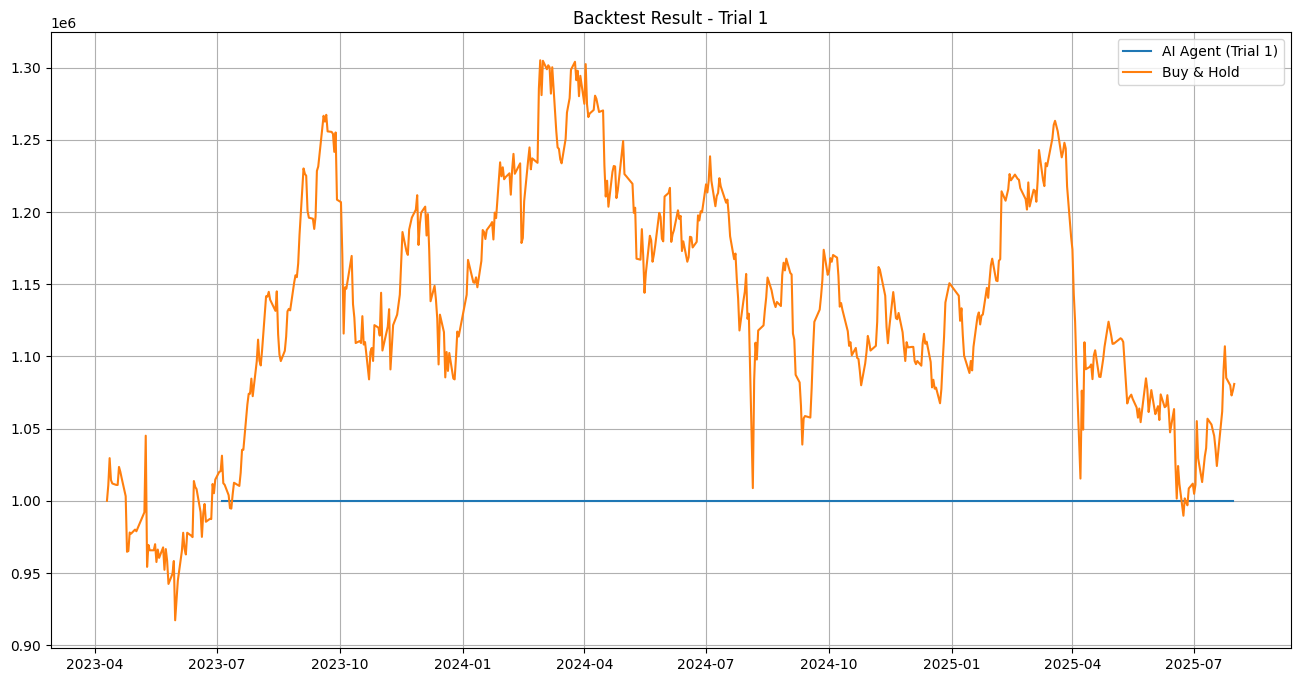


--- トライアル 2/2 を開始 ---
Using cuda device
----------------------------
| time/              |     |
|    fps             | 525 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 438         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.011446929 |
|    clip_fraction        | 0.0742      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.0474     |
|    learning_rate        | 0.001       |
|    loss                 | -0.0333     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0177     |
|    std                  | 0.995       |
|    value_loss           | 1.37        |


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver5-1だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 500000  # 各トライアルの学習ステップ数
NUM_TRIALS = 2  # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.001,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2015~2025.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'MA5', 'MA25', 'RSI', 'MACD_hist', 'BB_upper', 'BB_lower', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]
        additional_rewards=0

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                additional_rewards=0.001
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

        reward=additional_rewards

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 20:
            returns_array = np.array(self.daily_returns[-20:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward += sharpe_ratio  # スケーリングは状況見て調整
            """else:
                reward += 0
        else:
            reward +=0"""

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = PPO("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

ステップ1: データ準備を開始...
ステップ1: データ準備完了
カスタム指標の追加完了
             Close        RSI     BB_upper     BB_lower  Trend_signal
Date                                                                 
2025-07-25  2931.0  59.100186  2964.319621  2662.080379             1
2025-07-28  2917.0  57.586280  2974.600486  2671.099514             1
2025-07-29  2898.0  55.508131  2980.334245  2681.865755             1
2025-07-30  2907.0  56.312378  2983.256316  2698.243684             1
2025-07-31  2919.5  57.462473  2987.229834  2713.120166             1
--------------------------

ステップ4: 複数トライアルのモデル学習を開始します...

--- トライアル 1/5 を開始 ---
Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation market_data has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 80       |
|    time_elapsed    | 96       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 523      |
|    critic_loss     | 69.8     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 79       |
|    time_elapsed    | 195      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 847      |
|    critic_loss     | 592      |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps      

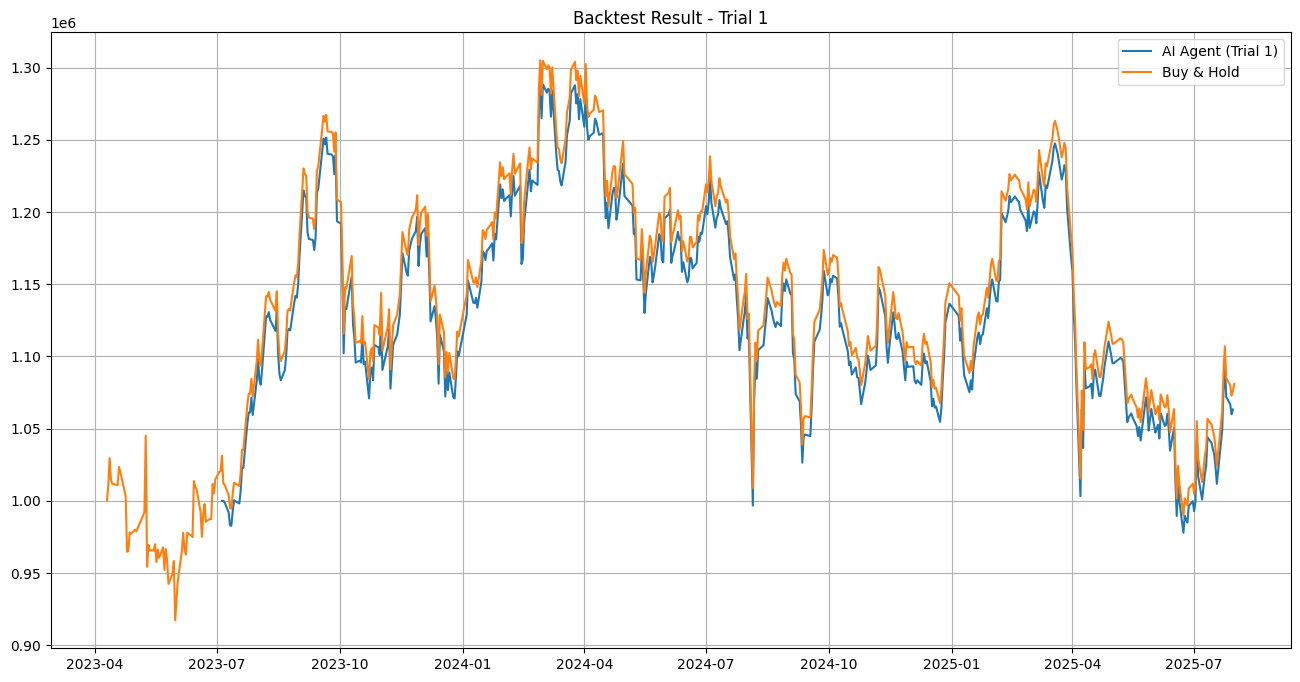


--- トライアル 2/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 94       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 509      |
|    critic_loss     | 78.4     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 190      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 914      |
|    critic_loss     | 77.7     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

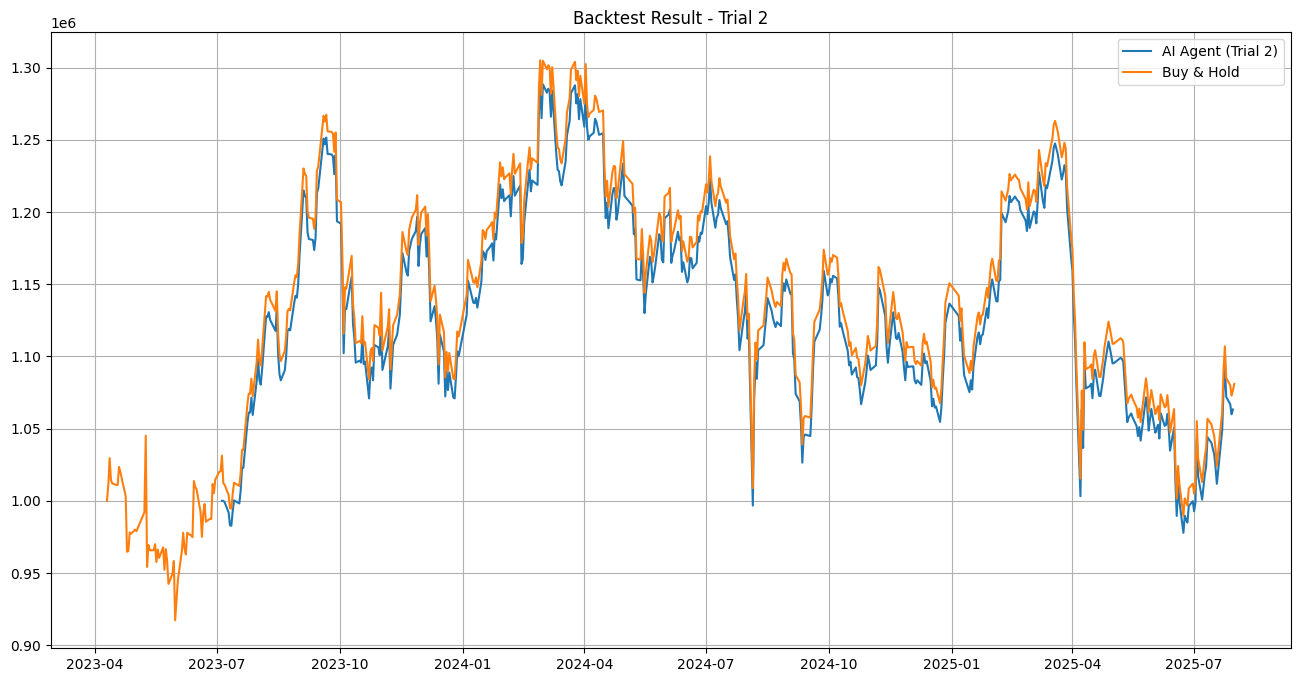


--- トライアル 3/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 81       |
|    time_elapsed    | 95       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 553      |
|    critic_loss     | 95.6     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 191      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 911      |
|    critic_loss     | 271      |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

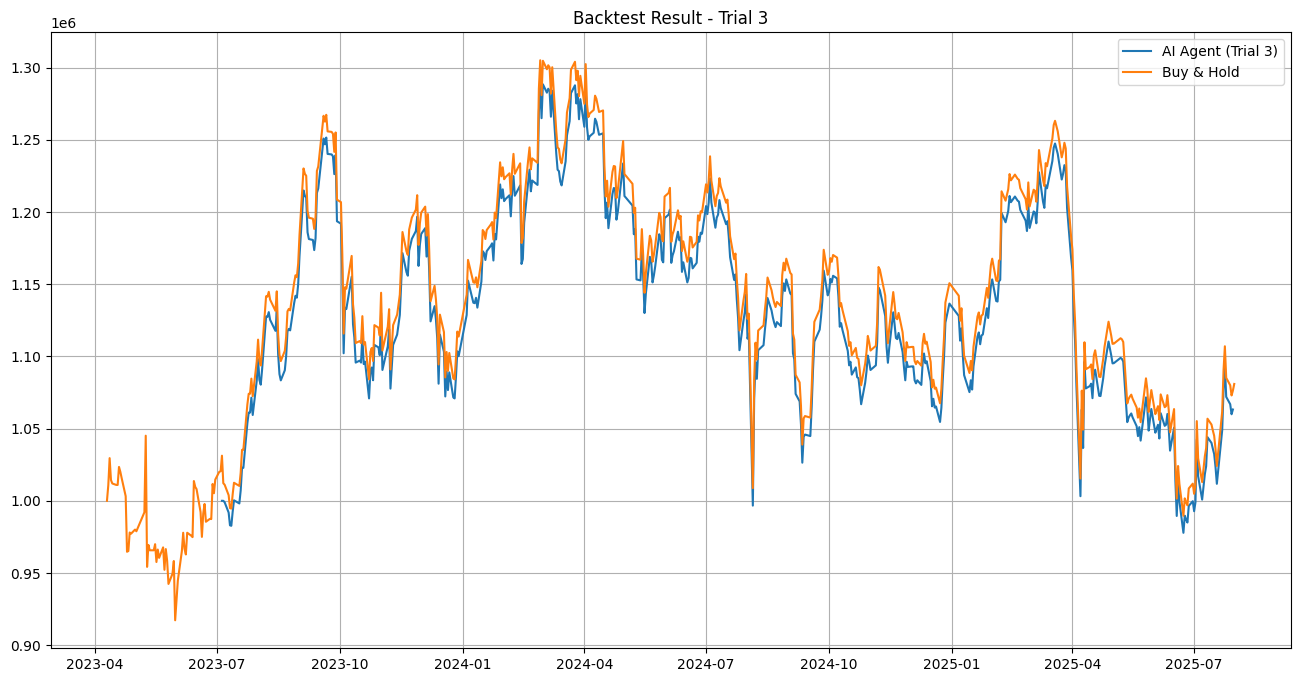


--- トライアル 4/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 94       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 164      |
|    critic_loss     | 13.7     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 191      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 297      |
|    critic_loss     | 7.04     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

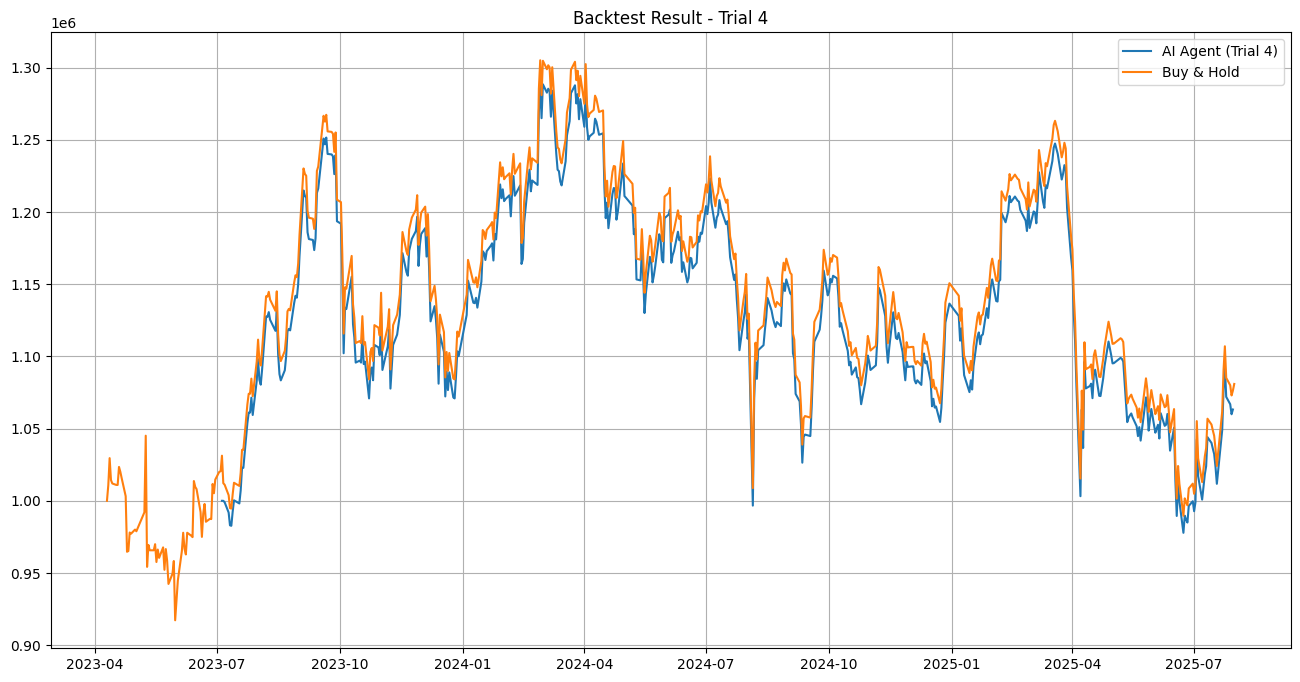


--- トライアル 5/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 83       |
|    time_elapsed    | 93       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 172      |
|    critic_loss     | 14.9     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 82       |
|    time_elapsed    | 189      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 300      |
|    critic_loss     | 47.7     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

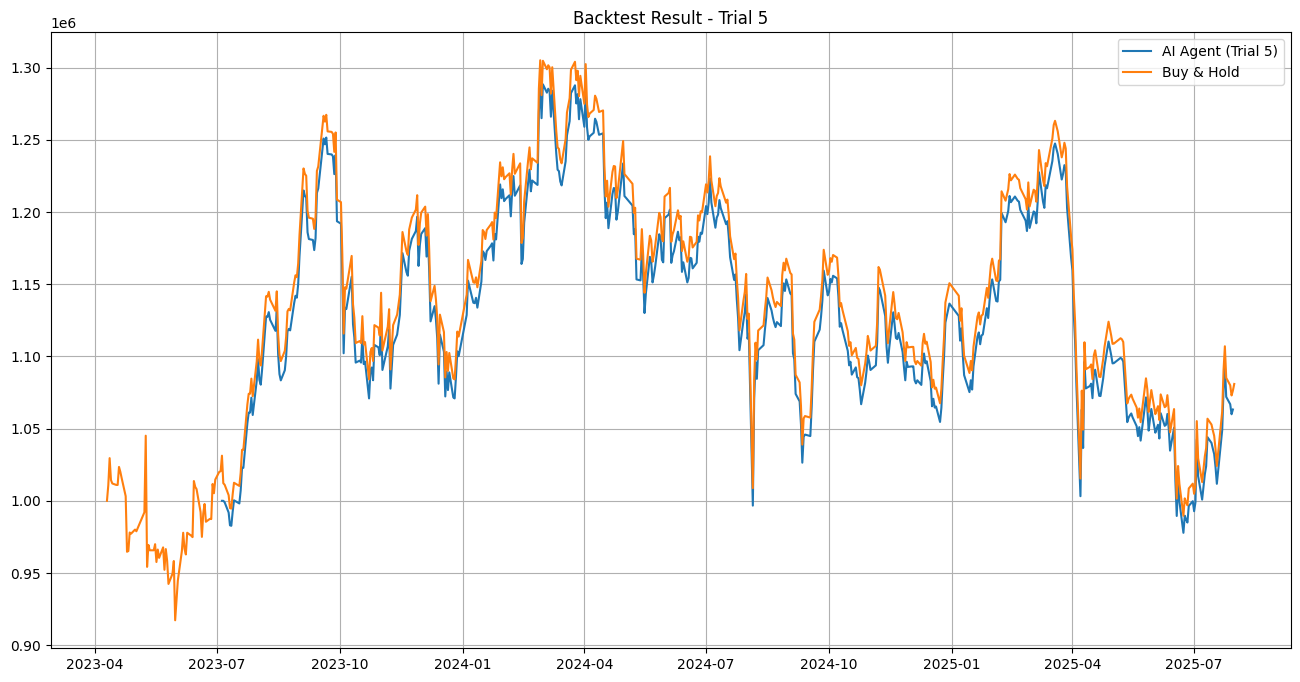



--- 全トライアル結果の集計 ---
試行回数: 5 回
平均資産: 1,063,235 円
最高資産: 1,063,235 円
最低資産: 1,063,235 円

最も成績の良かったトライアル: 1


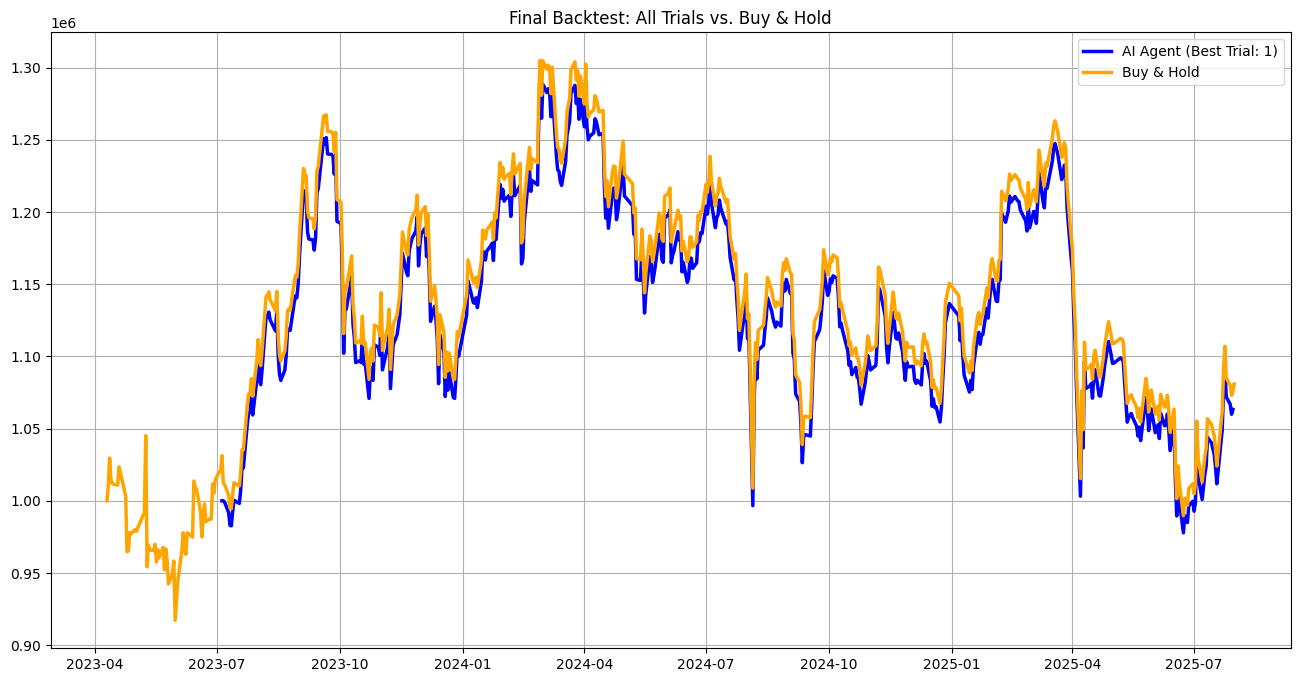

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces

import mathimport matplotlib.pyplot as plt
import os
import random
import statistics
from stable_baselines3 import PPO,SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver6-1だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 5 # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.05,
    'n_steps': 1,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2015~2025.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'RSI', 'BB_upper', 'BB_lower', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]
        additional_rewards=0

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                additional_rewards=0.001
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

        reward=additional_rewards

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 60:
            returns_array = np.array(self.daily_returns[-60:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward += sharpe_ratio  # スケーリングは状況見て調整
            """else:
                reward += 0
        else:
            reward +=0"""

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = SAC("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

ステップ1: データ準備を開始...
ステップ1: データ準備完了
カスタム指標の追加完了
             Close        RSI     BB_upper     BB_lower  Trend_signal
Date                                                                 
2025-07-25  2931.0  59.100186  2964.319621  2662.080379             1
2025-07-28  2917.0  57.586280  2974.600486  2671.099514             1
2025-07-29  2898.0  55.508131  2980.334245  2681.865755             1
2025-07-30  2907.0  56.312378  2983.256316  2698.243684             1
2025-07-31  2919.5  57.462473  2987.229834  2713.120166             1
--------------------------

ステップ4: 複数トライアルのモデル学習を開始します...

--- トライアル 1/5 を開始 ---
Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation market_data has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 80       |
|    time_elapsed    | 96       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 523      |
|    critic_loss     | 69.8     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 79       |
|    time_elapsed    | 195      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 847      |
|    critic_loss     | 592      |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps      

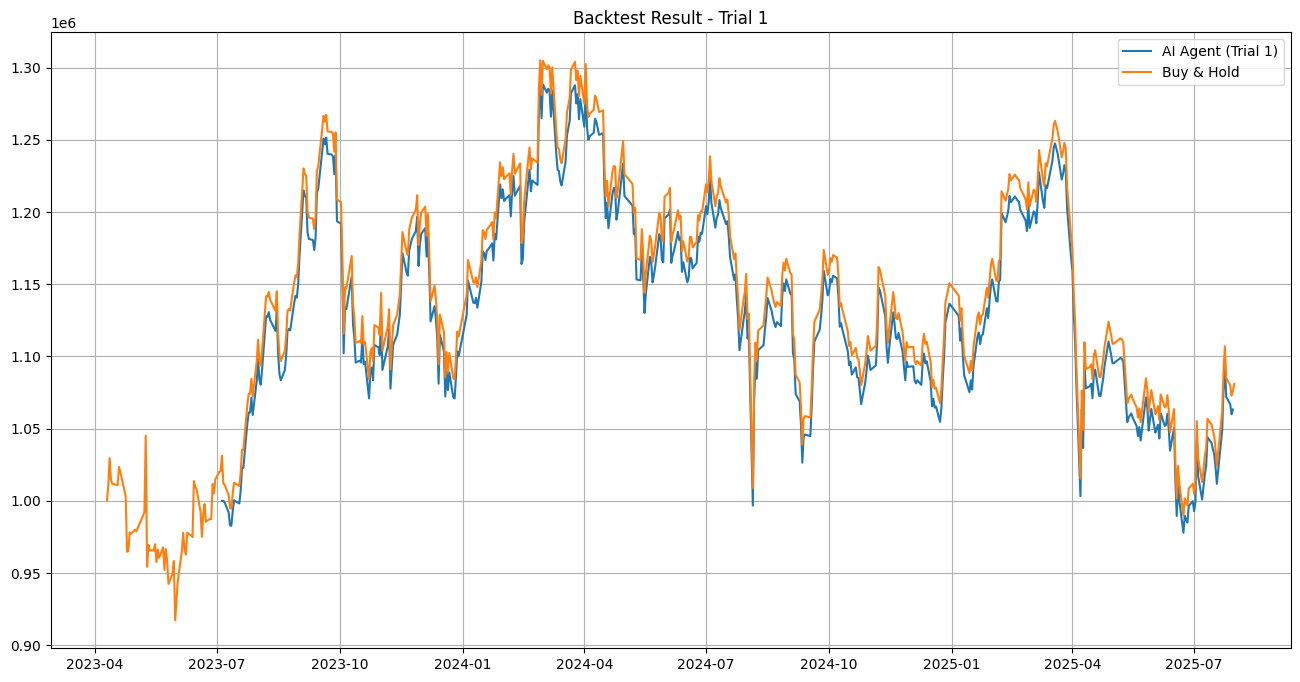


--- トライアル 2/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 94       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 509      |
|    critic_loss     | 78.4     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 190      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 914      |
|    critic_loss     | 77.7     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

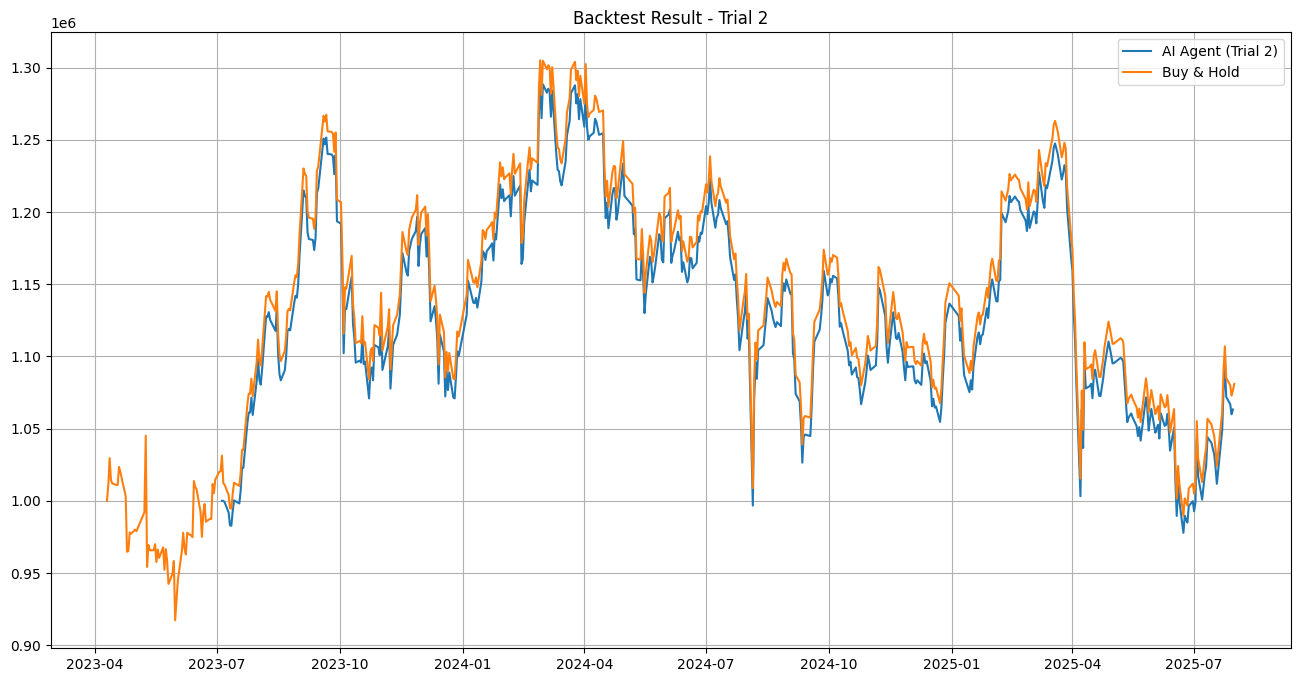


--- トライアル 3/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 81       |
|    time_elapsed    | 95       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 553      |
|    critic_loss     | 95.6     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 191      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 911      |
|    critic_loss     | 271      |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

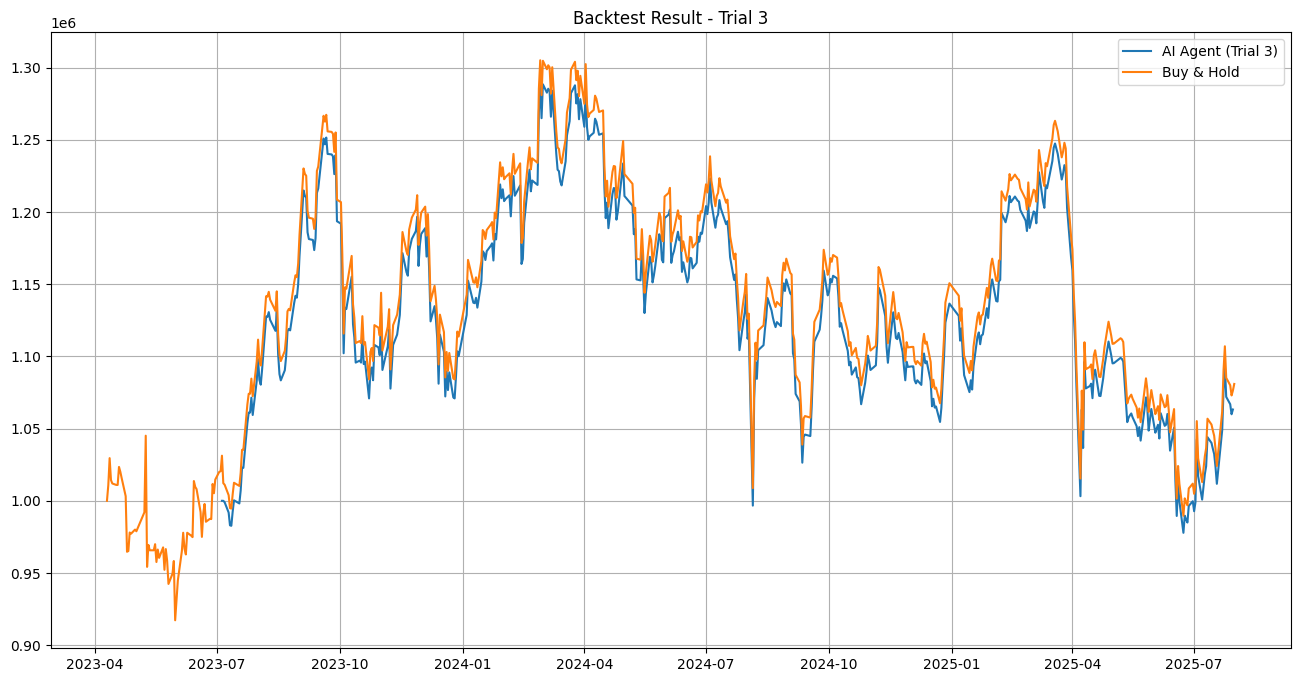


--- トライアル 4/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 82       |
|    time_elapsed    | 94       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 164      |
|    critic_loss     | 13.7     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 81       |
|    time_elapsed    | 191      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 297      |
|    critic_loss     | 7.04     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

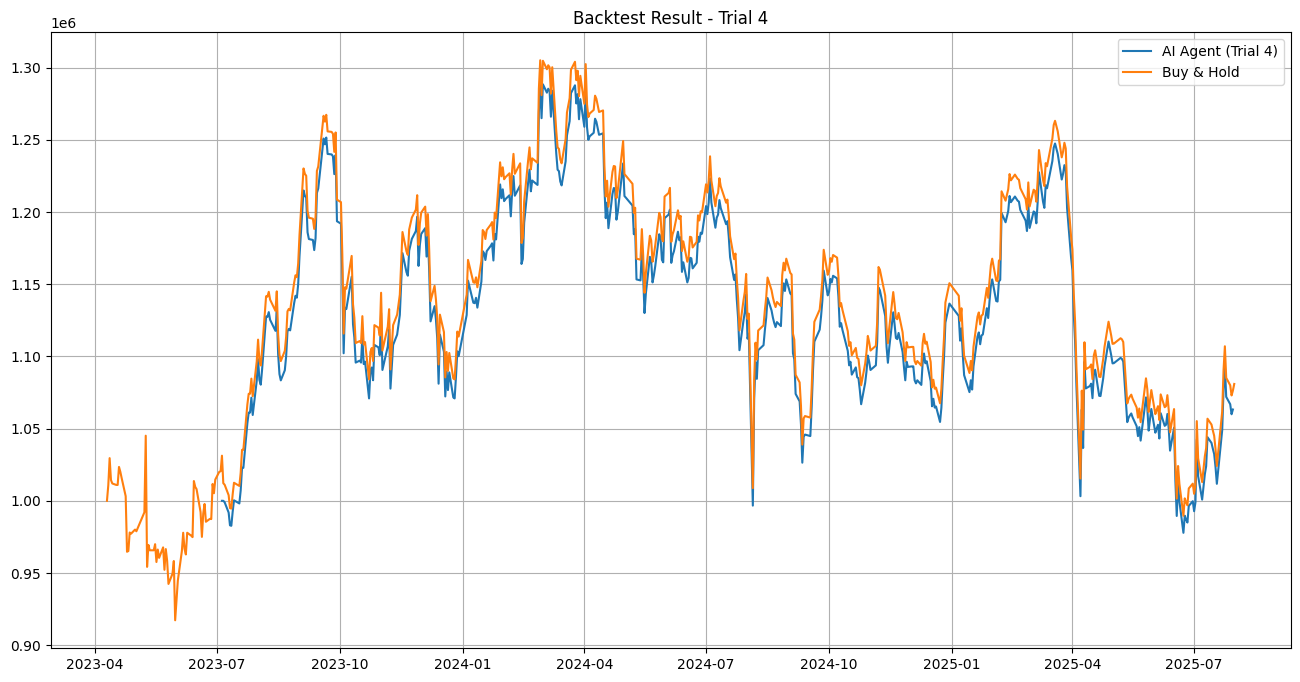


--- トライアル 5/5 を開始 ---
Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 83       |
|    time_elapsed    | 93       |
|    total_timesteps | 7784     |
| train/             |          |
|    actor_loss      | 172      |
|    critic_loss     | 14.9     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 7683     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 82       |
|    time_elapsed    | 189      |
|    total_timesteps | 15568    |
| train/             |          |
|    actor_loss      | 300      |
|    critic_loss     | 47.7     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.05     |
|    n_updates       | 15467    |
---------------------------------
---------------------------------
| time/              |          |
|    ep

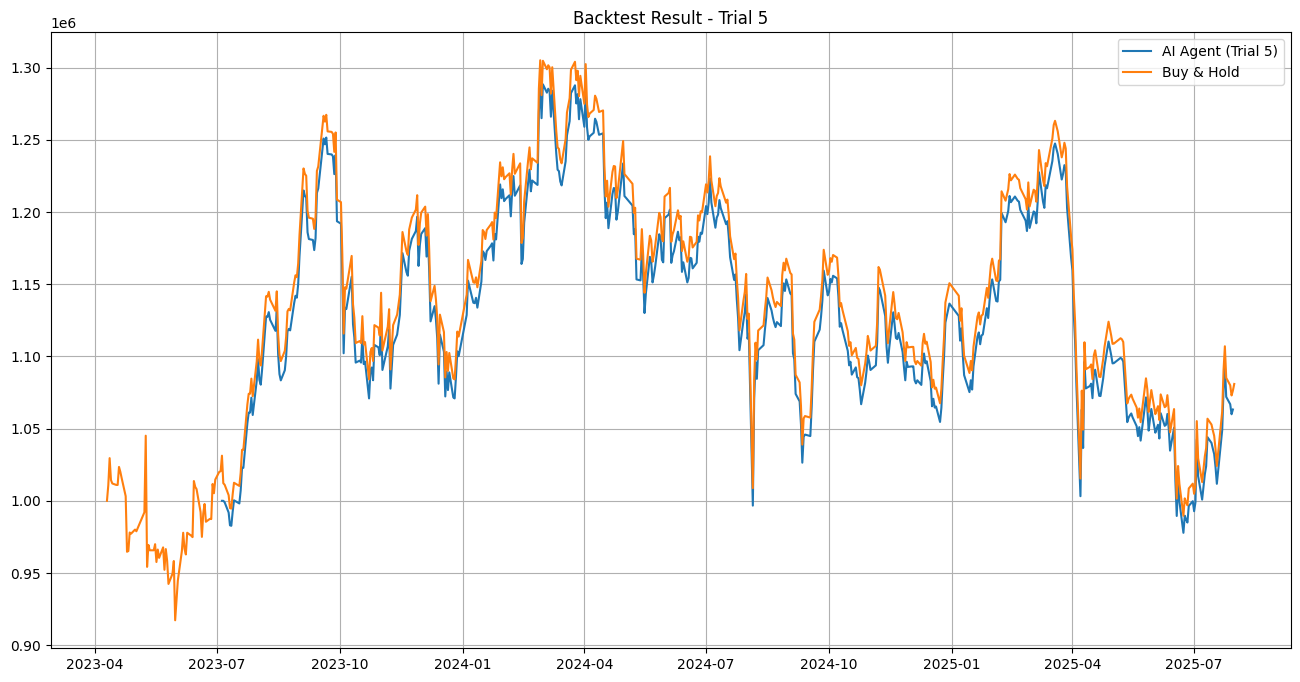



--- 全トライアル結果の集計 ---
試行回数: 5 回
平均資産: 1,063,235 円
最高資産: 1,063,235 円
最低資産: 1,063,235 円

最も成績の良かったトライアル: 1


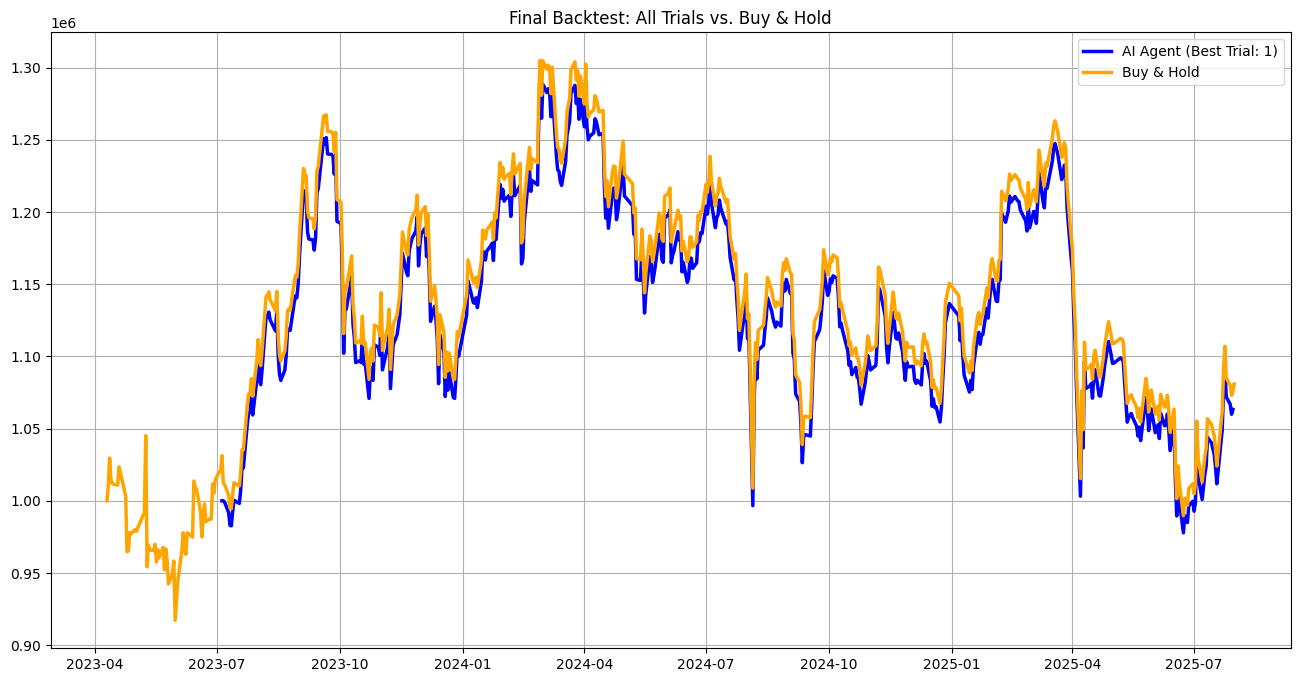

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO,SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver6-1だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 5 # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.05,
    'n_steps': 1,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2015~2025.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'RSI', 'BB_upper', 'BB_lower', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]
        additional_rewards=0

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                additional_rewards=0.001
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

        reward=additional_rewards

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 60:
            returns_array = np.array(self.daily_returns[-60:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward += sharpe_ratio  # スケーリングは状況見て調整
            """else:
                reward += 0
        else:
            reward +=0"""

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = SAC("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

ステップ1: データ準備を開始...
ステップ1: データ準備完了
カスタム指標の追加完了
             Close     MA5     MA25  MACD_hist  Trend_signal
Date                                                        
2025-07-25  2931.0  2900.0  2790.62  22.379445             1
2025-07-28  2917.0  2930.2  2798.00  19.449908             1
2025-07-29  2898.0  2936.2  2807.00  15.265387             1
2025-07-30  2907.0  2928.6  2815.06  12.265728             1
2025-07-31  2919.5  2914.5  2823.92  10.361370             1
--------------------------

ステップ4: 複数トライアルのモデル学習を開始します...

--- トライアル 1/5 を開始 ---
Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation market_data has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 436 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 311          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0038134838 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0876       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.412        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0092      |
|    std                  | 1.01         |
|    value_loss           | 1.44         |
-----------------------

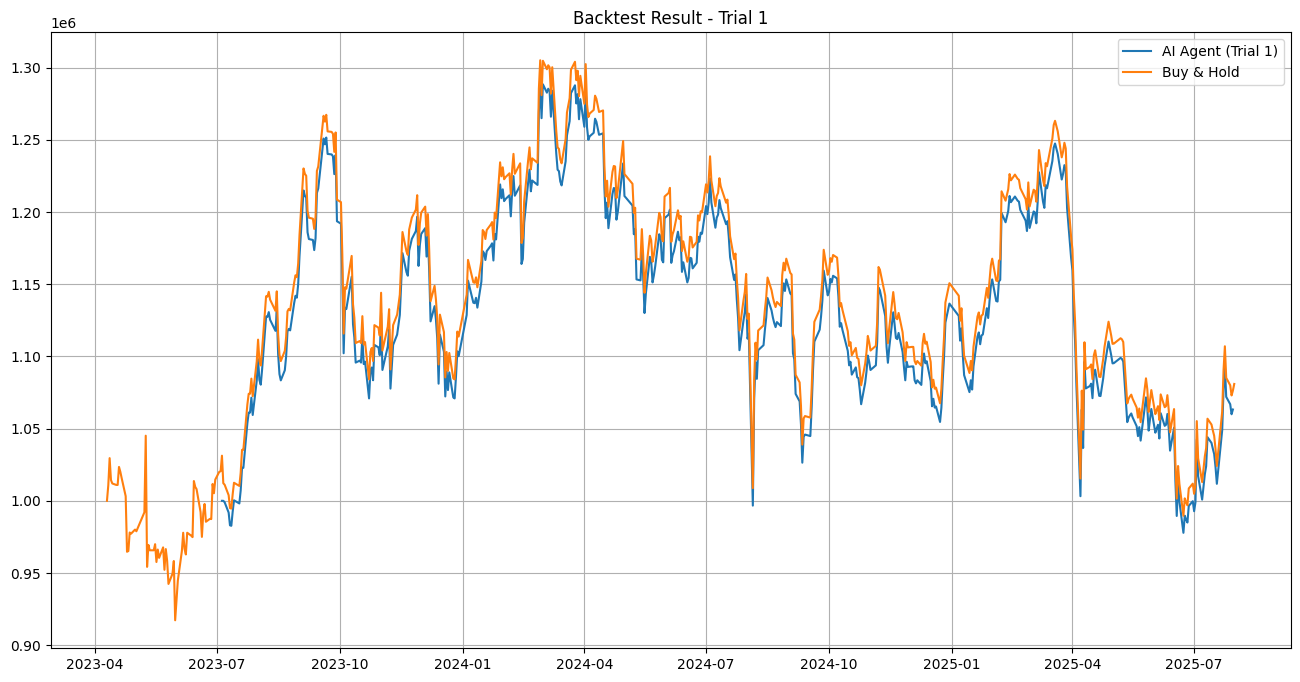


--- トライアル 2/5 を開始 ---
Using cuda device
----------------------------
| time/              |     |
|    fps             | 357 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008098042 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -0.0602     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.429       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00743    |
|    std                  | 0.987       |
|    value_loss           | 1.13        |


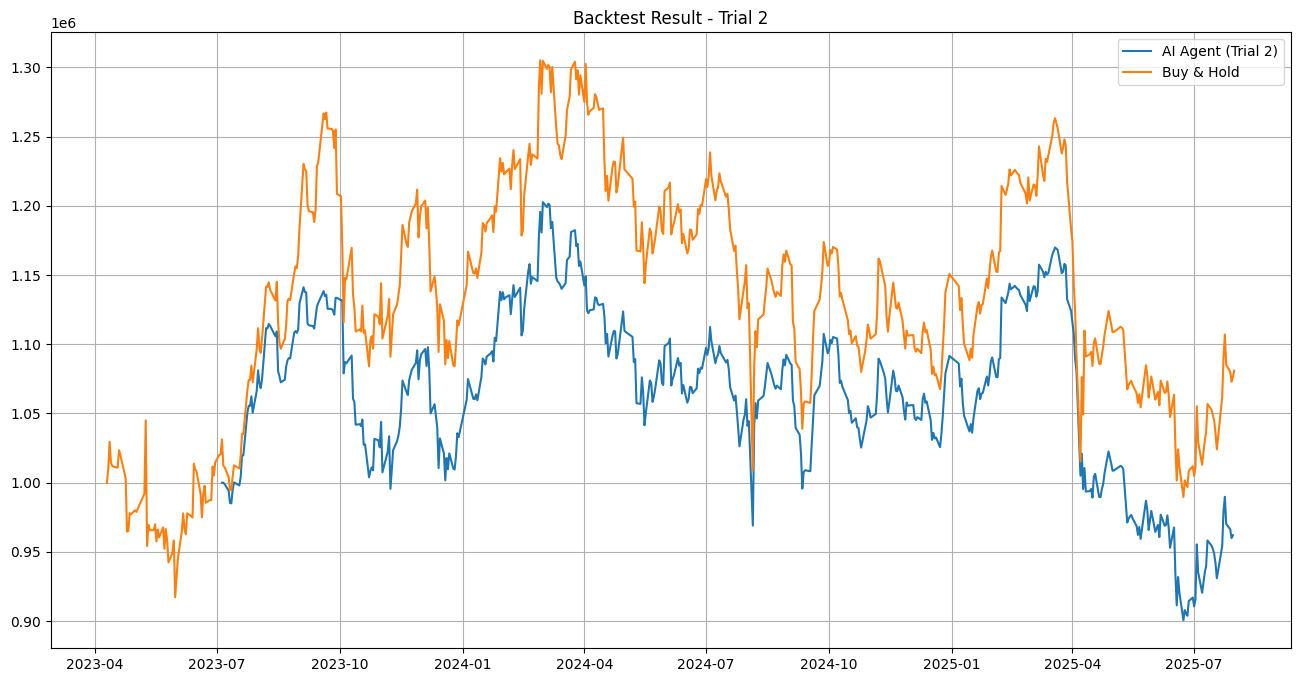


--- トライアル 3/5 を開始 ---
Using cuda device
----------------------------
| time/              |     |
|    fps             | 430 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 363         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.005982873 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.0656     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0174      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0124     |
|    std                  | 1           |
|    value_loss           | 0.621       |


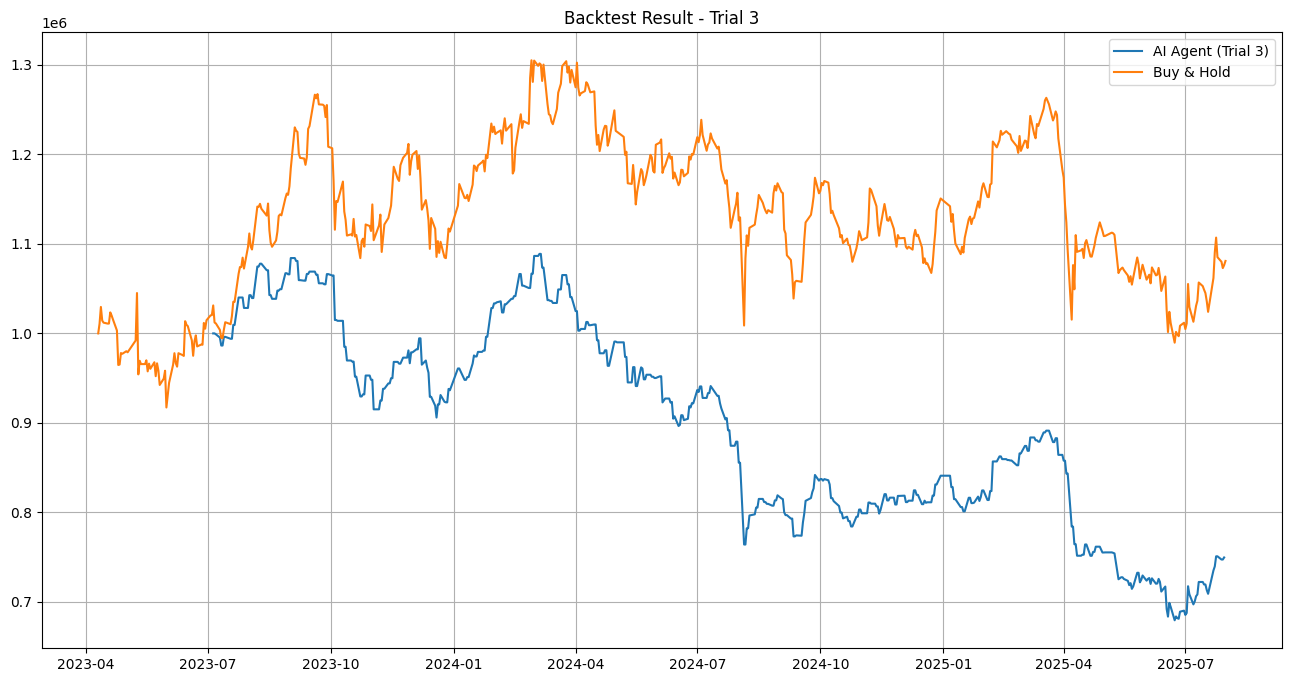


--- トライアル 4/5 を開始 ---
Using cuda device
----------------------------
| time/              |     |
|    fps             | 440 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 374          |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0021235908 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | -0.0173      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.64         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0052      |
|    std                  | 1.02         |
|    value_loss          

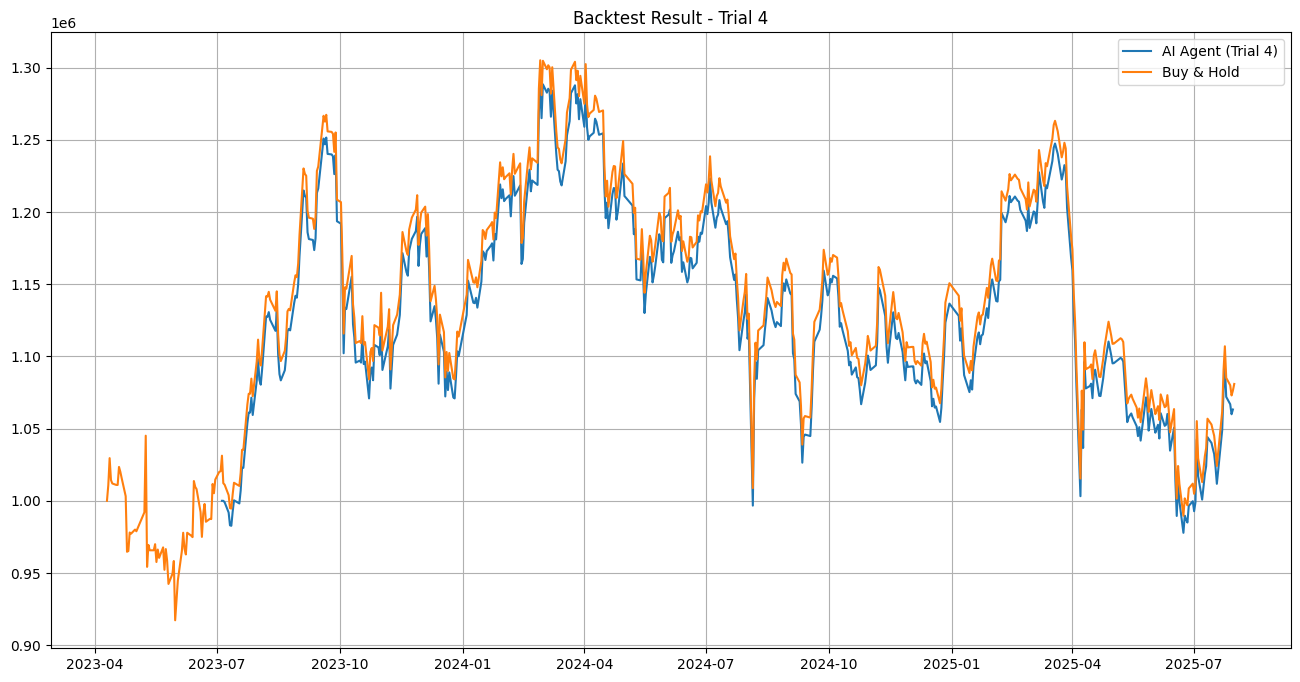


--- トライアル 5/5 を開始 ---
Using cuda device
----------------------------
| time/              |     |
|    fps             | 435 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 310         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.005772652 |
|    clip_fraction        | 0.0377      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.111       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.289       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0125     |
|    std                  | 1.01        |
|    value_loss           | 1.07        |


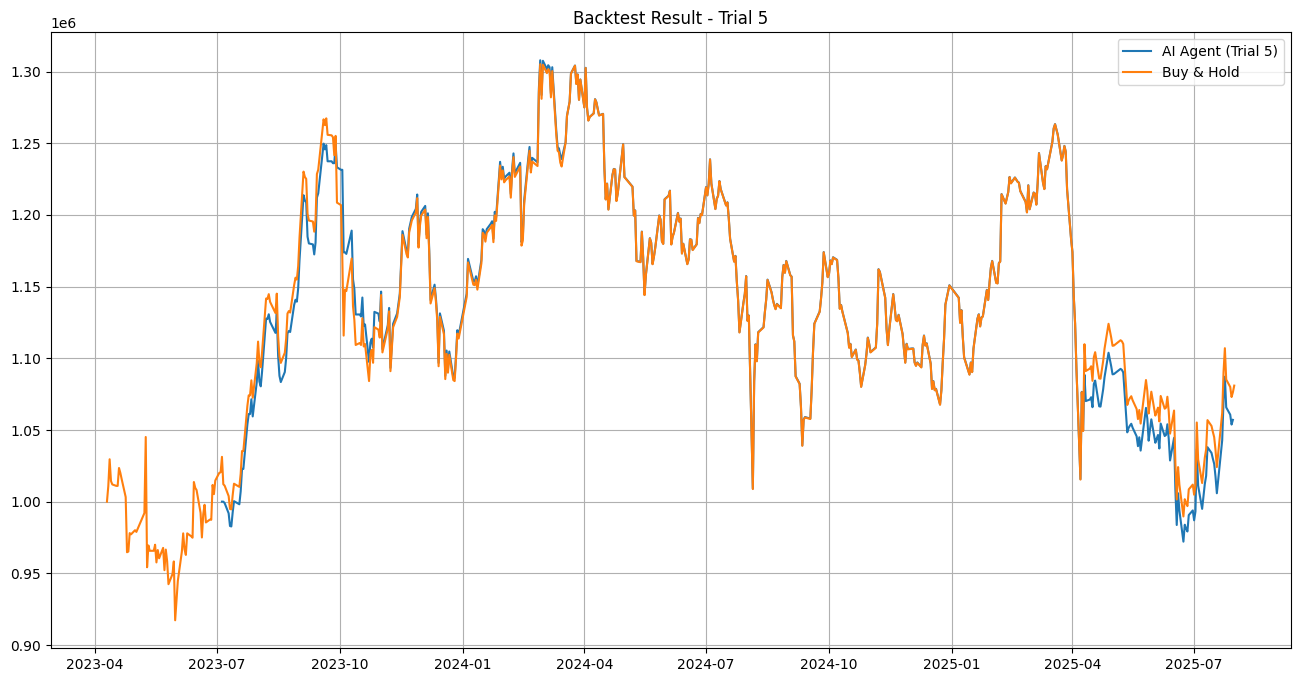



--- 全トライアル結果の集計 ---
試行回数: 5 回
平均資産: 979,043 円
最高資産: 1,063,235 円
最低資産: 749,689 円

最も成績の良かったトライアル: 1


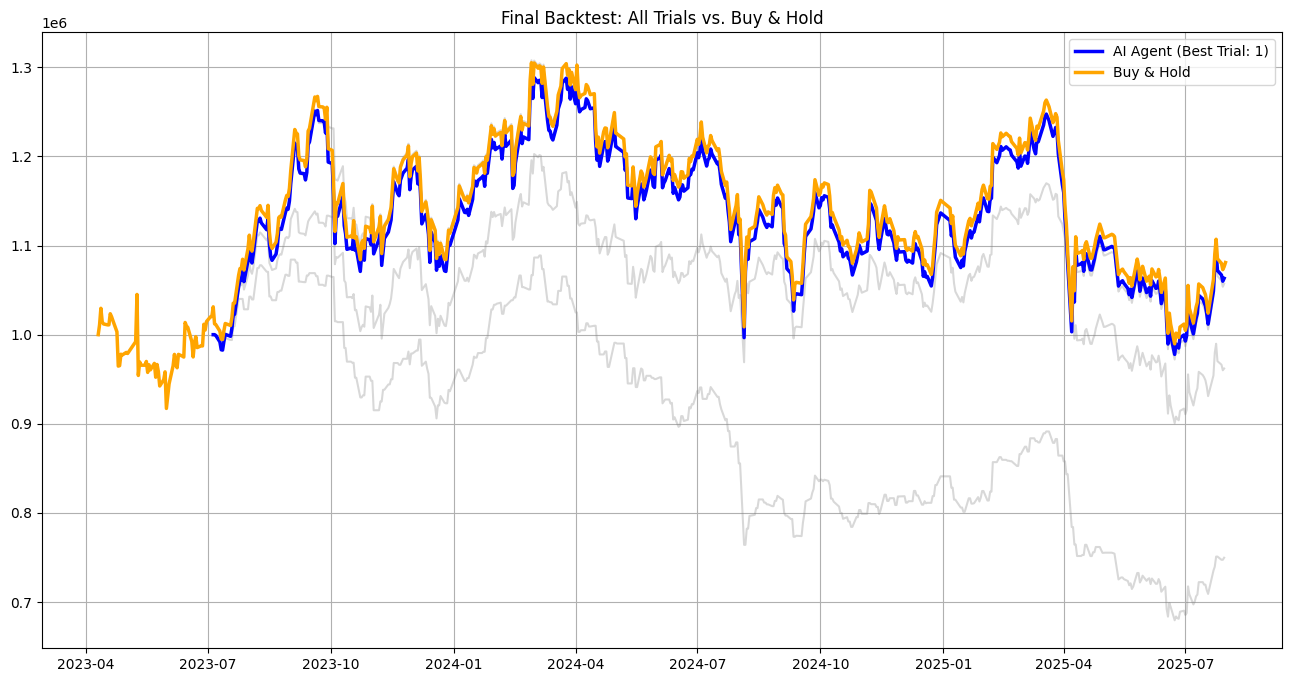

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver6-2順張り戦略だよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 5 # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.0003,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.5,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2015~2025.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'MA5', 'MA25', 'MACD_hist', 'Trend_signal']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]
        additional_rewards=0

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                additional_rewards=0.001
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

        reward=additional_rewards

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 20:
            returns_array = np.array(self.daily_returns[-20:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward += sharpe_ratio  # スケーリングは状況見て調整
            """else:
                reward += 0
        else:
            reward +=0"""

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        market_data = self.df.iloc[self.current_step - self.lookback:self.current_step].values
        agent_status = np.array([self.shares_held, self.balance], dtype=np.float32)
        return {"market_data": market_data.astype(np.float32), "agent_status": agent_status}

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = PPO("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()

ステップ1: データ準備を開始...
ステップ1: データ準備完了
カスタム指標の追加完了
             Close     MA5     MA25        RSI  MACD_hist     BB_upper  \
Date                                                                     
2025-07-25  2931.0  2900.0  2790.62  59.100186  22.379445  2964.319621   
2025-07-28  2917.0  2930.2  2798.00  57.586280  19.449908  2974.600486   
2025-07-29  2898.0  2936.2  2807.00  55.508131  15.265387  2980.334245   
2025-07-30  2907.0  2928.6  2815.06  56.312378  12.265728  2983.256316   
2025-07-31  2919.5  2914.5  2823.92  57.462473  10.361370  2987.229834   

               BB_lower  Trend_signal        ADX    STOCH_k  
Date                                                         
2025-07-25  2662.080379             1  24.793090  86.510965  
2025-07-28  2671.099514             1  24.950340  79.057592  
2025-07-29  2681.865755             1  25.060340  66.195213  
2025-07-30  2698.243684             1  25.272396  61.284853  
2025-07-31  2713.120166             1  25.933209  59.725109  
-

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation market_data has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 218 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 231          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0043353913 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.147       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0976       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00535     |
|    std                  | 0.993        |
|    value_loss           | 1.08         |
-----------------------

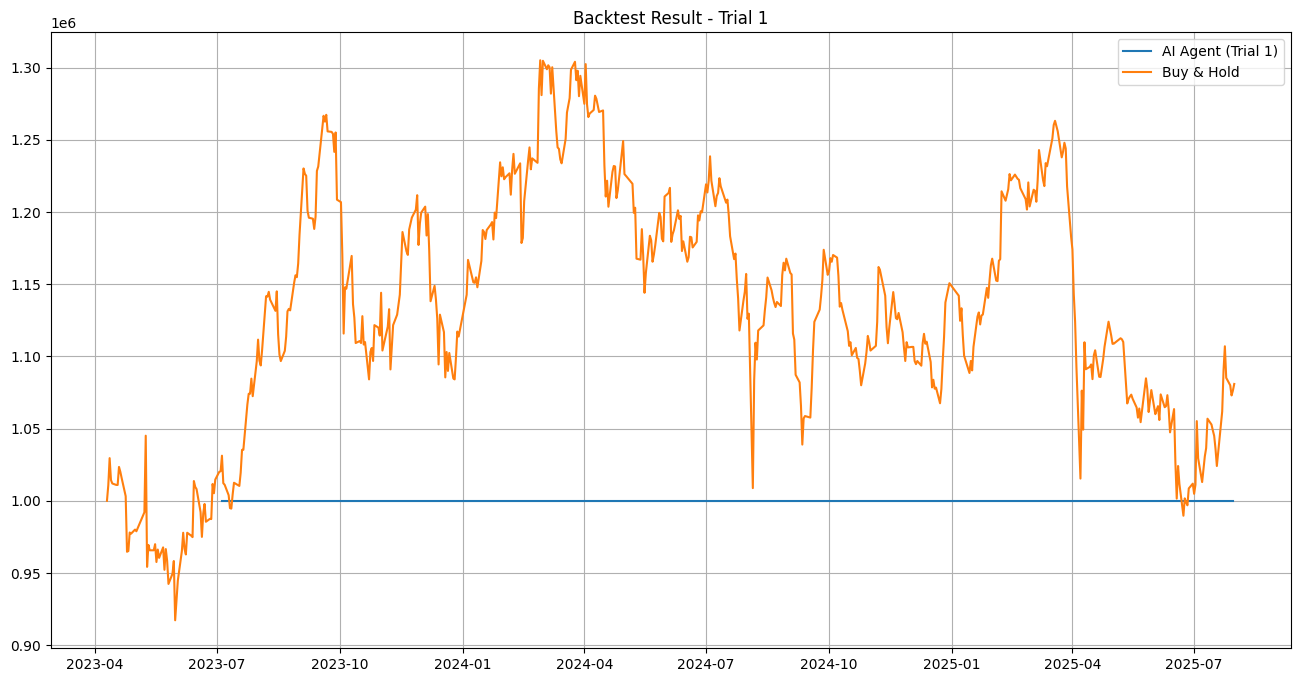


--- トライアル 2/2 を開始 ---
Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation market_data has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


----------------------------
| time/              |     |
|    fps             | 263 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 250         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.008868419 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.358      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.266       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00857    |
|    std                  | 0.996       |
|    value_loss           | 0.817       |
-----------------------------------------

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import math
import os
import random
import statistics
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


#ver6-3,順張り逆張り切り替えだよ！！！！！！！！！！

# --- 0. パラメータ設定 ---
INITIAL_BALANCE = 1_000_000
LOOKBACK_PERIOD = 60
FINETUNE_TIMESTEPS = 50000  # 各トライアルの学習ステップ数
NUM_TRIALS = 2  # 試行回数

BEST_PARAMS = {
    'learning_rate': 0.0003,
    'n_steps': 512,
    'gamma': 0.99,
    'ent_coef': 0.1,
    'batch_size': 64
}

# --- 1. データ準備 ---
print("ステップ1: データ準備を開始...")
file_name = 'Nipponsteel_stock_data2015~2025.csv'
df = pd.read_csv(
    file_name, header=0, skiprows=[1, 2], index_col='Price', parse_dates=True
)
df.index.name = 'Date'
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# テクニカル指標の計算
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
df['MA25'] = talib.SMA(df['Close'], timeperiod=25)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
df['P_DI'] = talib.PLUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['M_DI'] = talib.MINUS_DI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['STOCH_k'], df['STOCH_d'] = talib.STOCH(
    df['High'],
    df['Low'],
    df['Close'],
    fastk_period=14,
    slowk_period=3,
    slowd_period=3
)


# 特徴量エンジニアリング
df['Checker1'] = (df['MA5'] > df['MA25']).astype(int)
df['Checker2'] = (df['MACD'] > df['MACD_signal']).astype(int)
df['Checker3'] = (df['P_DI'] > df['M_DI']).astype(int)

# トレンドスコアを計算
df['Trend_detector'] = df[['Checker1', 'Checker2', 'Checker3']].sum(axis=1)
df['Trend_signal'] = np.where(df['Trend_detector'] >= 2, 1,  # 上昇トレンド
                             np.where(df['Trend_detector'] <= -2, -1,  # 下降トレンド
                                      0))  # レンジ

# NaNを削除
df.dropna(inplace=True)

# 特徴量リスト
features_to_use = ['Close', 'MA5', 'MA25', 'RSI', 'MACD_hist', 'BB_upper', 'BB_lower', 'Trend_signal','ADX','STOCH_k']
df_features = df[features_to_use]

# 訓練データとテストデータに分割
training_data_len = int(len(df_features) * 0.78)
train_df = df_features[:training_data_len]
test_df = df_features[training_data_len:]

print("ステップ1: データ準備完了")
print("カスタム指標の追加完了")
print(df_features.tail())
print("--------------------------\n")

# --- 2. カスタム環境定義 (シャープレシオ報酬版) ---
class StockTradingEnvSharpe(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.lookback = LOOKBACK_PERIOD
        self.initial_balance = INITIAL_BALANCE
        self.num_market_features = len(df.columns)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        # __init__メソッドの中

# 順張り戦略で使う特徴量
        self.trend_features = ['Close', 'MA5', 'MA25', 'MACD_hist', 'ADX']

# 逆張り戦略で使う特徴量
        self.reversal_features = ['Close', 'RSI', 'BB_upper', 'BB_lower', 'STOCH_k']
        self.observation_space = spaces.Dict({
            "market_data": spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_market_features), dtype=np.float32),
            "agent_status": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.average_purchase_price = 0
        self.current_step = self.lookback
        self.total_asset = self.balance
        self.prev_total_asset = self.total_asset
        self.daily_returns = []  # リターン履歴をリセット
        return self._get_observation(), {}

    def step(self, action):
        self.prev_total_asset = self.total_asset
        current_price = self.df.iloc[self.current_step]["Close"]
        action = action[0]
        additional_rewards=0

        if action > 0:
            amount_to_invest = self.balance * action
            num_shares_to_buy = int(amount_to_invest / current_price)
            if num_shares_to_buy > 0:
                actual_cost = num_shares_to_buy * current_price
                total_investment_before = self.average_purchase_price * self.shares_held
                self.shares_held += num_shares_to_buy
                self.average_purchase_price = (total_investment_before + actual_cost) / self.shares_held if self.shares_held > 0 else 0
                self.balance -= actual_cost
        elif action < 0:
            num_shares_to_sell = int(self.shares_held * abs(action))
            if num_shares_to_sell > 0:
                self.balance += num_shares_to_sell * current_price
                self.shares_held -= num_shares_to_sell
                additional_rewards=0.001
                if self.shares_held == 0:
                    self.average_purchase_price = 0

        self.current_step += 1
        self.total_asset = self.balance + (self.shares_held * current_price)

        daily_return = (self.total_asset / self.prev_total_asset) - 1 if self.prev_total_asset != 0 else 0
        self.daily_returns.append(daily_return)

        reward=additional_rewards

    # ローリングウィンドウでシャープレシオを計算
        if len(self.daily_returns) >= 20:
            returns_array = np.array(self.daily_returns[-20:])
            if returns_array.std() != 0:
                sharpe_ratio = returns_array.mean() / returns_array.std() * np.sqrt(252)
                reward += sharpe_ratio  # スケーリングは状況見て調整
            """else:
                reward += 0
        else:
            reward +=0"""

        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        obs = self._get_observation()
        info = {"total_asset": self.total_asset}
        return obs, reward, terminated, truncated, info

    def _get_observation(self):
        current_data=self.df.iloc[self.current_step]
        market_regime = current_data['Trend_signal']

    # 2. 市場状況に応じて、AIに渡す特徴量セットを切り替える
        if market_regime == 1: # 上昇トレンドの場合
        # 順張り用の特徴量だけを過去60日分切り出す
          market_observation = self.df[self.trend_features].iloc[self.current_step - self.lookback : self.current_step].values

        elif market_regime == -1: # 下降トレンドの場合（例として逆張りを選択）
        # 逆張り用の特徴量だけを過去60日分切り出す
          market_observation = self.df[self.reversal_features].iloc[self.current_step - self.lookback : self.current_step].values

        else: # レンジ相場の場合
        # 逆張り用の特徴量だけを過去60日分切り出す
          market_observation = self.df[self.reversal_features].iloc[self.current_step - self.lookback : self.current_step].values

    # 3. 最後に、エージェント自身の状態を結合する
        agent_status = np.array([self.shares_held / 10000, self.balance / self.initial_balance])


        if market_observation.shape[1] < self.observation_space["market_data"].shape[1]:
            # 足りない列数を計算
            padding_width = self.observation_space["market_data"].shape[1] - market_observation.shape[1]
            # 0で埋めるための配列を作成
            padding = np.zeros((self.lookback, padding_width))
            # 元のデータと結合して、列数を合わせる
            market_observation = np.hstack((market_observation, padding))

        agent_status = np.array([
        self.shares_held / 10000,
        self.balance / self.initial_balance
        ], dtype=np.float32)

    # 正しい形式でデータを返す
        return {
        "market_data": market_observation.astype(np.float32),
        "agent_status": agent_status
         }

# --- 3. バックテスト関数 ---
def run_backtest(model, env):
    # VecNormalize環境をアンラップして、元のカスタム環境にアクセス
    unwrapped_env = env.envs[0] if isinstance(env, VecNormalize) else env
    obs, info = unwrapped_env.reset()
    done = False
    asset_history_dict = {unwrapped_env.df.index[unwrapped_env.lookback-1]: unwrapped_env.initial_balance}
    for i in range(len(unwrapped_env.df) - unwrapped_env.lookback):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = unwrapped_env.step(action)
        done = terminated or truncated
        current_date = unwrapped_env.df.index[unwrapped_env.current_step - 1]
        asset_history_dict[current_date] = info['total_asset']
        if done:
            break
    return pd.Series(asset_history_dict)

# --- 4. 複数トライアルの実行 ---
print("ステップ4: 複数トライアルのモデル学習を開始します...")
all_trial_results = []

for i in range(NUM_TRIALS):
    print(f"\n--- トライアル {i + 1}/{NUM_TRIALS} を開始 ---")

    # ハードモード（シャープレシオ報酬）の環境を作成し、正規化
    train_env_raw = StockTradingEnvSharpe(df=train_df)
    check_env(train_env_raw)  # 環境のチェック
    train_env = VecNormalize(DummyVecEnv([lambda: train_env_raw]))

    # 新しいPPOモデルを初期化
    model = PPO("MultiInputPolicy", train_env, verbose=1, seed=random.randint(0, 1000000), **BEST_PARAMS)

    # パラメータの調整
    model.ent_coef = 0.01  # エントロピー係数を調整

    # 学習を実行
    model.learn(total_timesteps=FINETUNE_TIMESTEPS)
    print(f"--- トライアル {i + 1} 学習完了 ---")

    # 評価用の正規化環境を作成
    test_env_raw = StockTradingEnvSharpe(df=test_df)
    test_env = VecNormalize(DummyVecEnv([lambda: test_env_raw]), training=False, norm_reward=False)
    test_env.obs_rms = train_env.obs_rms  # 学習時の正規化統計を適用

    # バックテスト実行
    agent_performance = run_backtest(model, test_env)
    all_trial_results.append(agent_performance)

    print(f"--- トライアル {i + 1} 完了 | 最終資産: {agent_performance.iloc[-1]:,.0f} 円 ---")

    # 都度のグラフ表示
    buy_hold_performance = test_env_raw.initial_balance / test_env_raw.df.iloc[0]['Close'] * test_env_raw.df['Close']
    plt.figure(figsize=(16,8))
    plt.title(f'Backtest Result - Trial {i + 1}')
    plt.plot(agent_performance, label=f"AI Agent (Trial {i+1})")
    plt.plot(buy_hold_performance, label="Buy & Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. 最終評価 ---
print("\n\n--- 全トライアル結果の集計 ---")
final_assets = [result.iloc[-1] for result in all_trial_results]
print(f"試行回数: {NUM_TRIALS} 回")
print(f"平均資産: {np.mean(final_assets):,.0f} 円")
print(f"最高資産: {np.max(final_assets):,.0f} 円")
print(f"最低資産: {np.min(final_assets):,.0f} 円")

# 最も成績の良かったモデルのインデックスを取得
best_trial_index = np.argmax(final_assets)
best_performance_series = all_trial_results[best_trial_index]
print(f"\n最も成績の良かったトライアル: {best_trial_index + 1}")

# 最終的な統合グラフの描画
plt.figure(figsize=(16,8))
plt.title('Final Backtest: All Trials vs. Buy & Hold')
# 全トライアルの結果を薄い色でプロット
for i, result in enumerate(all_trial_results):
    if i == best_trial_index:
        continue
    plt.plot(result, color='gray', alpha=0.3, label='Other Trials' if i == 0 else None)

# 最も良かった結果を濃い色でプロット
plt.plot(best_performance_series, color='blue', linewidth=2.5, label=f"AI Agent (Best Trial: {best_trial_index+1})")
# Buy & Holdをプロット
final_test_env_raw = StockTradingEnvSharpe(df=test_df)
final_buy_hold_performance = final_test_env_raw.initial_balance / final_test_env_raw.df.iloc[0]['Close'] * final_test_env_raw.df['Close']
plt.plot(final_buy_hold_performance, color='orange', linewidth=2.5, label="Buy & Hold")

plt.legend()
plt.grid(True)
plt.show()